# Example Exploratory Data Analysis

Basic data science workflow consists of the following steps:

- Understand
- Aquire
- Explore
- Clean
- Model
- Evaluate
- Communicate

It is important to note that these steps are applied in an iterative fashion, meaning we repeat the process based on insights gained from previous iterations.

Lets do a first iteration!

## Understand

In this step we formulate a question or hypothesis of interest with regard to the data at hand.

Since we might not be familiar with the data set yet, an initial generic question of interest can be **how is the data distributed at large and are there any spatio-temporal patterns?**.

## Aquire

We look at the MVG Bike Trips data from the year 2020, which is available for download from <https://www.mvg.de/dam/jcr:fd647823-ad3e-44c4-9f72-c431b31278fa/MVG_Rad_Fahrten_2020.zip>.

The following code snippes downloads the zip file, extracts its content into the `target_dir` and then prints all files in this directory.

In [1]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from pathlib import Path


# specify a target directory to extract zip content
target_dir = Path("./data")
# create if it does not exists
target_dir.mkdir(parents=True, exist_ok=True)

# link to the data
url = "https://www.mvg.de/dam/jcr:fd647823-ad3e-44c4-9f72-c431b31278fa/MVG_Rad_Fahrten_2020.zip"
# open url
response = urlopen(url)

# read zipfile
with ZipFile(BytesIO(response.read())) as zipfile:
    # extract the content
    zipfile.extractall(target_dir)

# print all files in the target directory
for path in target_dir.glob("*"):
    print(path)

data/MVG_Rad_Fahrten_2020.csv


In case everything was working out, the output should be `data/MVG_Rad_Fahrten_2020.csv`

## Clean

Often the data needs some cleanup for further processing. Things to clean are missing values, encoding of values, artifacts and so on.

Lets load the data and have a look at it to see if there needs to be some cleanup:

In [2]:
# read the csv as text file and print first 10 lines
with open("./data/MVG_Rad_Fahrten_2020.csv", "r") as file:
    for i in range(10):
        print(file.readline())

Row   ;STARTTIME       ;ENDTIME         ;STARTLAT;STARTLON ;ENDLAT   ;ENDLON   ;RENTAL_IS_STATION;RENTAL_STATION_NAME                         ;RETURN_IS_STATION;RETURN_STATION_NAME                         

1     ;2020-01-01 00:10;2020-01-01 00:21;48,16957;11,58736 ;48,16568 ;11,56474 ;0                ;                                            ;0                ;                                            

2     ;2020-01-01 00:14;2020-01-01 00:32;48,13652;11,5929  ;48,13502 ;11,57901 ;0                ;                                            ;0                ;                                            

3     ;2020-01-01 00:25;2020-01-01 00:41;48,1706 ;11,54881 ;48,16562 ;11,5648  ;0                ;                                            ;0                ;                                            

4     ;2020-01-01 00:29;2020-01-01 00:43;48,17433;11,56033 ;48,17326 ;11,59075 ;0                ;                                            ;0                ;           

Some things to not here are:

- the csv contains a `header row` with attribute names
- the delimiter is `;`
- there seems to be a row index `Row`
- `STARTTIME` and `ENDTIME` look like **timestamps** of the form `yyyy-mm-dd hh:mm` (lets hope month and day are not switched which is common for the US date format)
- `STARTLAT`, `STARTLON`, `ENDLAT` and `ENDLON` are **floating point** coordinates in the `WGS84` coordinate reference system and the decimal separator is `,`
- `RENTAL_IS_STATION` and `RETURN_IS_STATION` seem to be of type **boolean** (0 = False, 1 = True) as indicated by the `_IS_` in the attribute name
- `RENTAL_STATION_NAME` and `RETURN_STATION_NAME` are most likely of type **string** given the suffix `_NAME`
- there is some whitespace attached at the end of fields to make them equal spacing.

The last remark turns out to be annoying for future processing so we remove the whitespace once and for all.

In [3]:
import re

with open("./data/MVG_Rad_Fahrten_2020.csv", "r") as input:
    with open("./data/MVG_Rad_Fahrten_2020_cleaned.csv", "w") as output:
        for line in input.readlines():
            # remove all whitespace preceeding ;
            line = re.sub("\s*;", ";", line, flags=re.M)
            # remove all whitespace preceeding a new line
            line = re.sub("\s*\n", "\n", line, flags=re.M)

            output.write(line)

Now lets read this cleaned csv into a Pandas dataframe.

In [4]:
import pandas as pd

# read the cleaned csv with pandas into a dataframe
df = pd.read_csv(
    "./data/MVG_Rad_Fahrten_2020_cleaned.csv",
    sep=";",
    header=0,
    index_col="Row",
    parse_dates=["STARTTIME", "ENDTIME"],
    decimal=",",
)

# print dimensions (rows, columns)
print("Shape:")
print(df.shape)
print()
# print column names
print("Columns:")
print(df.columns)
print()
# print data types
print("Data types:")
print(df.dtypes)

# display the first few rows
df.head()

Shape:
(721752, 10)

Columns:
Index(['STARTTIME', 'ENDTIME', 'STARTLAT', 'STARTLON', 'ENDLAT', 'ENDLON',
       'RENTAL_IS_STATION', 'RENTAL_STATION_NAME', 'RETURN_IS_STATION',
       'RETURN_STATION_NAME'],
      dtype='object')

Data types:
STARTTIME              datetime64[ns]
ENDTIME                datetime64[ns]
STARTLAT                      float64
STARTLON                      float64
ENDLAT                        float64
ENDLON                        float64
RENTAL_IS_STATION             float64
RENTAL_STATION_NAME            object
RETURN_IS_STATION             float64
RETURN_STATION_NAME            object
dtype: object


,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME
Row,,,,,,,,,,
1,2020-01-01 00:10:00,2020-01-01 00:21:00,48.16957,11.58736,48.16568,11.56474,0.0,NaN,0.0,NaN
2,2020-01-01 00:14:00,2020-01-01 00:32:00,48.13652,11.59290,48.13502,11.57901,0.0,NaN,0.0,NaN
3,2020-01-01 00:25:00,2020-01-01 00:41:00,48.17060,11.54881,48.16562,11.56480,0.0,NaN,0.0,NaN
4,2020-01-01 00:29:00,2020-01-01 00:43:00,48.17433,11.56033,48.17326,11.59075,0.0,NaN,0.0,NaN
5,2020-01-01 00:29:00,2020-01-01 00:30:00,48.12354,11.53372,48.12374,11.53319,0.0,NaN,0.0,NaN


As you can see from the output the dataset consists of `721752 observations` of `11 attributes`.

Some data types are still off like the boolean columns are of type `float64`. We can change that later if needed, for now we continue with exploring the data contents.

## Explore

A basic exploration step is to get an overview of the attributes, whether they are discrete or continuous, how many values are missing and some basic statistics. 

### Descriptive Statistics

For numeric attributes, we can do this by using the `describe` function. For boolean and textual attributes we can use `value_counts`.

In [5]:
df.describe()

,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RETURN_IS_STATION
count,721752,721752,721752.000000,721752.000000,721752.000000,721752.000000,721744.000000,721750.000000
mean,2020-07-09 16:16:05.706779904,2020-07-09 16:51:09.570545152,47.973013,11.527437,47.872160,11.503403,0.265821,0.211454
min,2020-01-01 00:10:00,2020-01-01 00:21:00,0.000000,-84.581660,-21.122510,-84.581660,0.000000,0.000000
25%,2020-05-11 12:49:45,2020-05-11 13:13:45,48.128470,11.547380,48.128510,11.547250,0.000000,0.000000
50%,2020-07-20 08:13:30,2020-07-20 08:33:00,48.145590,11.568180,48.145490,11.568260,0.000000,0.000000
75%,2020-09-12 15:35:00,2020-09-12 16:14:15,48.161360,11.587270,48.161340,11.587270,1.000000,0.000000
max,2020-12-31 22:45:00,2021-01-03 10:54:00,53.566620,111.604960,53.566620,149.192180,1.000000,1.000000
std,NaN,NaN,2.885016,0.727901,3.625459,0.931709,0.441770,0.408340


In [6]:
df["RENTAL_IS_STATION"].value_counts()

RENTAL_IS_STATION
0.0    529889
1.0    191855
Name: count, dtype: int64

In [7]:
df["RENTAL_STATION_NAME"].value_counts()

RENTAL_STATION_NAME
Münchner Freiheit              3457
Sandstraße                     3180
Olympiazentrum                 3022
Rotkreuzplatz                  2776
Maillingerstraße               2679
                               ... 
Rathaus Oberhaching              19
Bogenstraße Waldbrunn            17
Amselstraße Gudrunsiedlung       12
Waldstraße Neukirchstockach      10
Waldsiedlung Faistenhaar          5
Name: count, Length: 305, dtype: int64

From the numeric statistics we see that that the `STARTTIME` and `ENDTIME` are distributed accross the whole year with the `mean` in early June. The `mean` and `std` of the coordinate columns centers around Munich as expected. Suspicious are the unreasonable `min` and `max` values that we will need to filter out.

From the value count we see that less than a third of the trips start at a rental station and some popular locations are Münchner Freiheit, Sandstrasse and Olympiazentrum among others.

### Visualizations

Data vizualization is essential for building up a deeper understanding of the data especially for spatio-temporal pattern which are not easy to comprehend from descriptive statistics. In order to have better support for spatial data, we first convert the data to a GeoPandas dataframe and as well clip the extent of the observations to the greater Munich area.

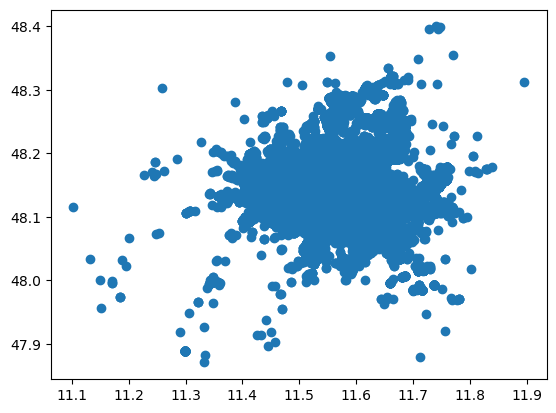

In [8]:
import matplotlib.pyplot as plt

# filter observations in the greater munich area
df = df.query("STARTLAT > 47.8 and STARTLAT < 48.4")
df = df.query("STARTLON > 11.1 and STARTLON < 11.9")
df = df.query("ENDLAT > 47.8 and ENDLAT < 48.4")
df = df.query("ENDLON > 11.1 and ENDLON < 11.9")

# scatter plot of starting points
plt.scatter(df["STARTLON"], df["STARTLAT"])

In [ ]:
# you might need to install contextily. Uncomment the following line, in case you get an error:
# !pip install contextily

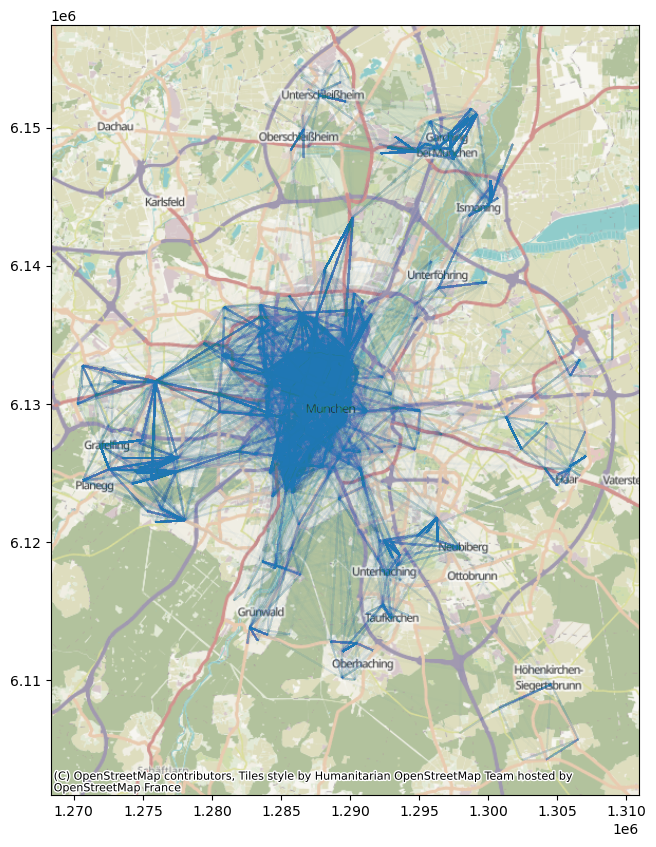

In [9]:
import contextily as cx
import geopandas
import shapely

# create a geometry (line segment) from the coordinates
geometries = df.apply(
    lambda x: shapely.LineString(
        [[x["STARTLON"], x["STARTLAT"]], [x["ENDLON"], x["ENDLAT"]]]
    ),
    axis=1,
)

# convert to geo data frame
gdf = geopandas.GeoDataFrame(df, geometry=geometries, crs="EPSG:4326")

# plot lines
ax = gdf.to_crs(epsg=3857).dropna().plot(figsize=(10, 10), alpha=0.01)
# add basemaps
cx.add_basemap(ax, zoom=11)

(array([ 36264.,  44926.,  35756.,  45820.,  60363.,  76910., 105872.,
         95750.,  85658.,  62020.,  41454.,  24152.]),
 array([18262.00694444, 18292.50202546, 18322.99710648, 18353.4921875 ,
        18383.98726852, 18414.48234954, 18444.97743056, 18475.47251157,
        18505.96759259, 18536.46267361, 18566.95775463, 18597.45283565,
        18627.94791667]),
 <BarContainer object of 12 artists>)

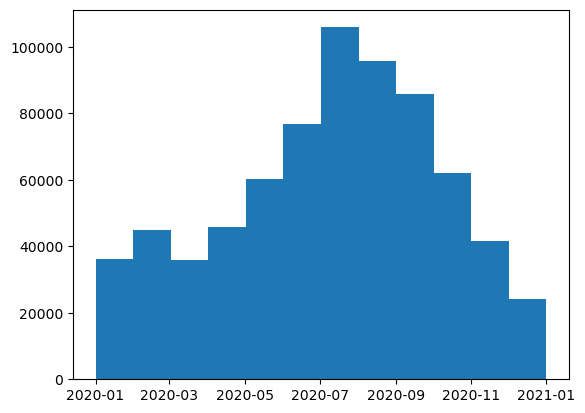

In [10]:
# histogram of the start time
import matplotlib.pyplot as plt

plt.hist(df["STARTTIME"], bins=12)


<Axes: xlabel='STARTTIME'>

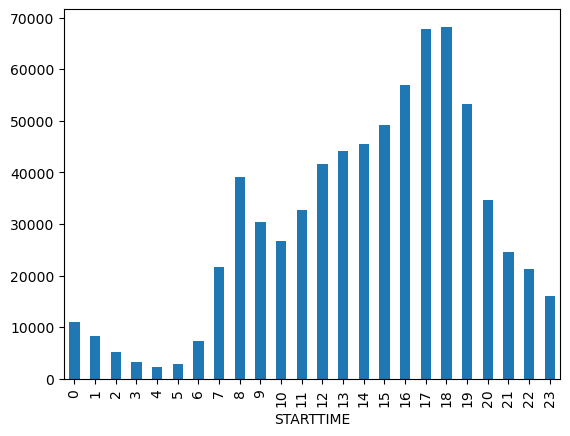

In [11]:
df["STARTTIME"].groupby(df["STARTTIME"].dt.hour).count().plot(kind="bar")

The `temporal plots` display seasonal and daily patterns, peaking in summer and daytime. The `spatial plots` shows a cluster towards the city center and some outliers.

After the initial data exploration, before modelling is a good time to reviese our understanding. What did we learn about the data? What can we already say about our question? What new questions arise? Do we need some more data cleaning? Feature engineering? Additional data?

## Model

Modeling is used to elaborate more specific spatio-temoral relationships. The idea is to create a model that can help unravel and explain real world phenomena from measured proxis. There are an amplitude of analythical approaches to choose, each with its own strength and drawbacks. Often these models have some requirements and assumptions on the input data and its modalities. Finding the right model to answer the question from the given data can be nontrivial.

### Feature Engineering

For some questions and modeling approaches new features are required not explicitly present in the raw data. For example we might concretize our question to what spatio-temporal patterns are there with regard to the travel speed. Are we driving faster in summer than in winter? For this we need to engineer some features like duration of the trip and the distance.

<Axes: >

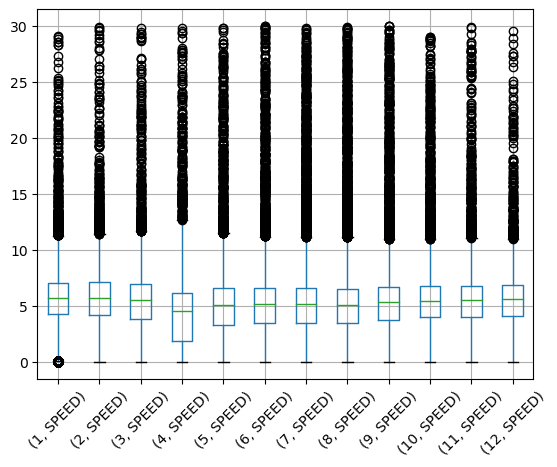

In [12]:
from math import radians, cos, sin, asin, sqrt

# trip duration
df["DURATION"] = df["ENDTIME"] - df["STARTTIME"]


# distance
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 3956  # Radius of earth in miles. Use 6371 for kilometers
    return c * r


df["DISTANCE"] = df.apply(
    lambda x: haversine(x["STARTLON"], x["STARTLAT"], x["ENDLON"], x["ENDLAT"]), axis=1
)

# speed
df["SPEED"] = df.apply(
    lambda x: 0
    if x["DURATION"].total_seconds() == 0
    else x["DISTANCE"] / x["DURATION"].total_seconds() * 60 * 60,
    axis=1,
)

# boxplot of speed by month
df.query("SPEED < 30 and SPEED >= 0").groupby(
    gdf["STARTTIME"].apply(lambda x: x.month)
).boxplot(subplots=False, column="SPEED", rot=45)

The boxplot shows that the average speed is slightly higher in winter months though speeding is more unlikely than in Summer.

### *k*-Means

*k*-Means is a clustering algorithm that works by iteratively partitioning data points into *k* clusters, where *k* is a user-defined parameter, and assigns each data point to the cluster with the nearest mean or centroid.

As an exaple of usage we naivly cluster the `STARTLON` and `STARTLAT` for demonstration purposes. Note that this is rather simplified. In reality one might need more preprocessing of the input like data type conversions, scaling and/or dimentionality reduction.

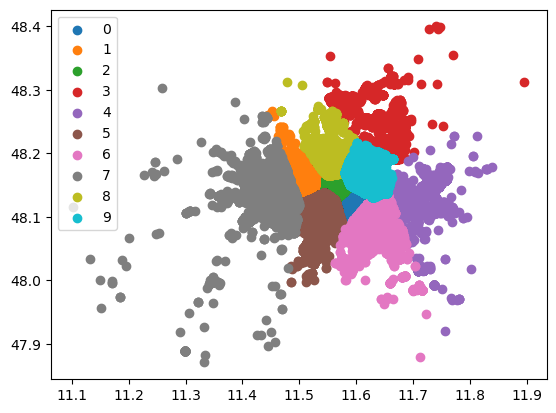

In [13]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np

# extract input data
X = df[["STARTLON", "STARTLAT"]].copy()

# predict the labels of clusters.
km = KMeans(n_clusters=10, n_init="auto")
km.fit(X)

labels = km.labels_

# plotting the results
for i in np.unique(labels):
    plt.scatter(
        X.loc[labels == i, "STARTLON"],
        X.loc[labels == i, "STARTLAT"],
        label=i,
    )
plt.legend(loc="upper left")
plt.show()

*k*-means implies that one knows how many cluster are in the data. If one is not sure there are helpers like the `elbow method` to find out a sensible value for *k*. Another evaluation method is `silhouette analysis`.

Text(0, 0.5, 'Sum of squared distance')

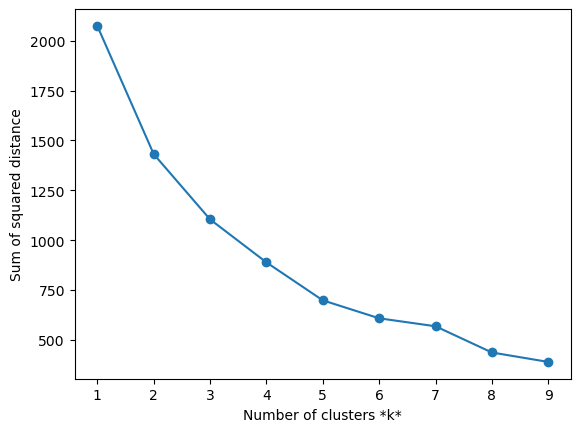

In [14]:
X = df[["STARTLON", "STARTLAT"]].copy()

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, n_init="auto")
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.plot(list_k, sse, "-o")
plt.xlabel(r"Number of clusters *k*")
plt.ylabel("Sum of squared distance")

Generally one tries to find the a small *k* with small distance which is generally the elbo point of the line. In the picture above the line is rather shaped like a curve, indicating ther is not exeptional value for *k* to look at. This can have many reasons, maybe there are no clusters in the data as it is distributed rather normal or meaningfull clusters have complex bounds that can not be represented with the convex partitioning of the *k*-Means approach.

### DBSCAN

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering algorithm used in data analysis. Unlike K-Means, DBSCAN does not require the user to specify the number of clusters in advance. Instead, it groups data points based on their density, identifying clusters as areas of high data point density separated by areas of lower density, while also being able to detect and label outliers as noise. DBSCAN is effective at discovering clusters of arbitrary shapes and is robust to variations in cluster density, making it a valuable tool for various clustering tasks.

Input shape: (714945, 2)


Text(0.5, 1.0, 'Estimated number of clusters: 2531')

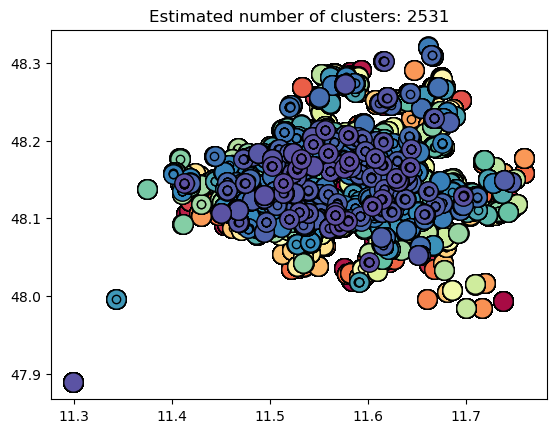

In [15]:
import numpy as np
from sklearn.cluster import DBSCAN


# extract input data
X = df[["STARTLON", "STARTLAT"]].copy()
print("Input shape:", X.shape)

# add some jitter to prevent duplicate records which dbscan fails to handle.
# alternatively one could group by and use the count to generate a weight.
X["STARTLON"] = X["STARTLON"] + ((np.random.random(len(X)) - 0.5) * 0.000001)
X["STARTLAT"] = X["STARTLAT"] + ((np.random.random(len(X)) - 0.5) * 0.000001)

X = X.values

# dbscan
db = DBSCAN(eps=0.0003, min_samples=10, algorithm="ball_tree", metric="haversine")
db.fit(X)

labels = db.labels_

# plot
unique_labels = set(labels)
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")

Due to the low value of `eps` the estimated number of clusters is quite high. If first filter the records for `RENTAL_IS_STATION` bevore we extract the input, the estimated number of clusters is equal to the amount of stations.

In [16]:
df["RENTAL_STATION_NAME"].unique().shape

(306,)

We could for example use this clustering to find locations for new stations and use the point count per cluster for priority. Also we can see that there are many clusters on both sides of the Isar when using all data, though most stations are to the left of the Isar and only a few on the right when we filter.